# Аналитика аренды самокатов GoFast  

## Описание проекта  

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.  

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:  
* без подписки
    * абонентская плата отсутствует;
    * стоимость одной минуты поездки — 8 рублей;
    * стоимость старта (начала поездки) — 50 рублей;
* с подпиской Ultra
    * абонентская плата — 199 рублей в месяц;
    * стоимость одной минуты поездки — 6 рублей;
    * стоимость старта — бесплатно.  
    
## Ход исследования  

Данные получены из 3х различных датасетов -  `users_go.csv`, `rides_go.csv`, `subscriptions_go.csv`. О качестве данных ничего неизвестно. Перед исследованием понадобится обзор данных.  

После обзора данных понадобится предобработка данных: приведение столбцов к необходимым типам данных, проверка на пропущенные значения и дубликаты.  
После предобработки перейдем к исследовательскому анализу данных - опишем и визуализируем общую информацию о пользователях и поездках.  
Потом объединим данные из трех датасетов в один. Подсчитаем выручку, проверим поставленные ранее гипотезы и подберем параметры распределения, описывающего ситуацию, в которой определим какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.

Таким образом, исследование пройдет в 7 этапов:
1. Изучение общей информации
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение данных
5. Подсчет выручки  
6. Проверка гипотез  
7. Распределение

## Описание данных    

В основных данных есть информация о пользователях, их поездках и подписках.

**Пользователи** — `users_go.csv`
* `user_id` - уникальный идентификатор пользователя
* `name` - имя пользователя
* `age` - возраст
* `city` - город
* `subscription_type` - тип подписки (free, ultra)

**Поездки** — `rides_go.csv` 
* `user_id` - уникальный идентификатор пользователя
* `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)
* `duration` - продолжительность сессии (в минутах) - время, с того момента, как пользователь нажать кнопку "Начать поездку" до момента, как он нажал кнопку "Завершить поездку"
* `date` - дата совершения поездки

**Подписки** — `subscriptions_go.csv` 
* `subscription_type` - тип подписки
* `minute_price` - стоимость одной минуты поездки по данной подписке
* `start_ride_price` - стоимость начала поездки
* `subscription_fee` - стоимость ежемесячного платежа

## 1. Изучение общей информации 

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from math import sqrt
from scipy import stats as st
from scipy.stats import binom, poisson, norm

sns.set(color_codes=True)

import warnings

In [2]:
# увеличим максимальное количество отображающихся столбцов
pd.set_option('display.max_columns', None)

# Вывести из под комментария перед финальным запуском:
# Игнорируем предупреждения о возможных изменения работы фуфнкций в будущих версиях в Pandas
warnings.filterwarnings("ignore")

In [3]:
# считывание csv-файлов
try:
    df_rides = pd.read_csv('/datasets/rides_go.csv')
    df_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
    df_users = pd.read_csv('/datasets/users_go.csv')
except:
    df_rides = pd.read_csv('rides_go.csv')
    df_subscriptions = pd.read_csv('subscriptions_go.csv')
    df_users = pd.read_csv('users_go.csv')

## `rides_go`

In [4]:
# выведем первые 5 строк датафрейма
df_rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [5]:
# выведем общую онфирмацию о таблице
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [6]:
# выведем общую информацию о количественных данных в таблице
df_rides.describe()

,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


В таблице `rides_go` пропуски в данных отсутствуют. Видно несоответствие типа данных столбца `date` - необходимо будет исправить на этапе обработки данных.  

Минимальная длительность поездки - пол минуты, минимальное расстояние 0,8 метра. Вероятно, пользователь практически сразу нажал кнопку "Завершить поездку" после ее начала. 

## `subscriptions_go`

In [7]:
# выведем датафрейм
df_subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
# выведем общую онфирмацию о таблице
df_subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Описание расценок с подпиской Ultra и без подписки соответствует описанию к данным.

## `users_go`

In [9]:
# выведем первые 5 строк датафрейма
df_users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [10]:
# выведем общую онфирмацию о таблице
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [11]:
# выведем общую информацию о количественных данных в таблице
df_users.describe()

,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


В датасете `users_go` пропуски в данных отсутствуют. Возможны дубликаты в названиях городов, проверим на этапе обработки данных.

**Выводы**  

Данные по поездкам представлены 18тыс. значений. Данных по пользователям около 1,5тыс. значений.  

Присутствуют несоответствия типов данных в столбцах, которые необходимо будет устранить. Также возможно присутствие дубликатов, необходимо проверить.

## 2. Предобработка данных

Приведем столбец `date` таблицы `rides` в формат даты и проверим за какой период предоставлены данные.

Дата первой публикации объявлений: 2021-01-01 00:00:00
Дата последней публикации объявлений: 2021-12-30 00:00:00


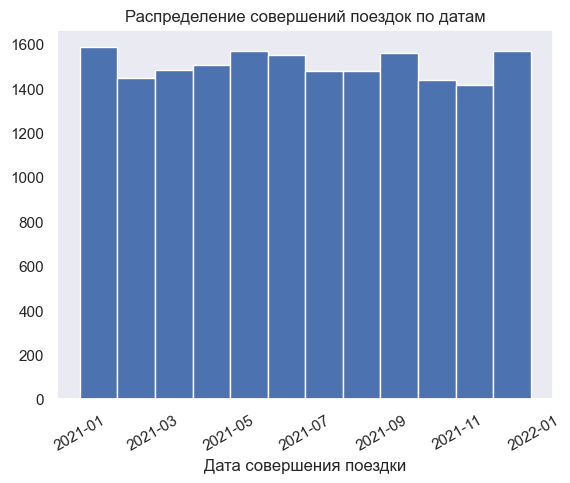

In [12]:
df_rides['date'] = pd.to_datetime(df_rides['date'], format='%Y-%m-%d')

# Выведем первую и последнюю даты публикации объявлений
print('Дата первой публикации объявлений:', df_rides['date'].min())
print('Дата последней публикации объявлений:', df_rides['date'].max())

# Построим гистрограмму распределения кол-ва публикаций по датам
plt.hist(df_rides['date'], bins=12)
plt.grid() # включим отображение сетки
plt.xticks(rotation=30) # повернем название дат для корректного отображения
plt.xlabel('Дата совершения поездки') # подпишем ось Х
plt.title('Распределение совершений поездок по датам') # дадим название гистограмме
plt.show()

Представленный период совершений поездок - 2021 год.  
В каждый месяц совершалось не менее 1400 поездок.

In [13]:
# Создадим новый столбец с номерами месяцов
df_rides['month'] = pd.to_datetime(df_rides["date"]).dt.month

# Выведем первые 5 строк для проверки
df_rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [14]:
# посмотрим долю пропусков
pd.DataFrame(round(df_rides.isna().mean().sort_values(ascending=False)*100,1)).style.background_gradient('coolwarm')

,0
user_id,0.000000
distance,0.000000
duration,0.000000
date,0.000000
month,0.000000


Пропуски отсутствуют.  

In [15]:
# округлим расстояния в таблице rides до 2х знаков после запятой
df_rides['distance'] = df_rides['distance'].round(2)
df_rides.head()

,user_id,distance,duration,date,month
0,1,4409.92,25.599769,2021-01-01,1
1,1,2617.59,15.816871,2021-01-18,1
2,1,754.16,6.232113,2021-04-20,4
3,1,2694.78,18.511000,2021-08-11,8
4,1,4028.69,26.265803,2021-08-28,8


<AxesSubplot:>

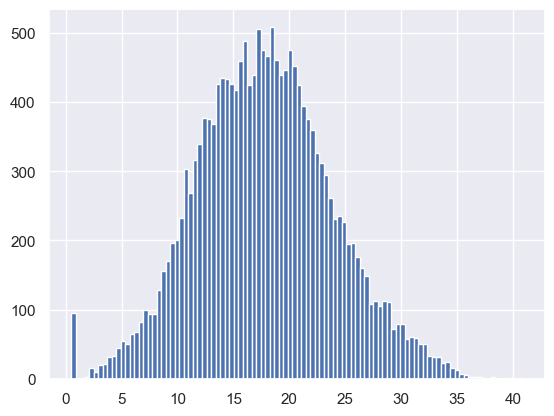

In [16]:
# проверим длительности поездок на наличие аномалий
df_rides['duration'].hist(bins=100)

Видны аномалии в поездах меньше одной минуты, выглядит странно, уточним.

<AxesSubplot:>

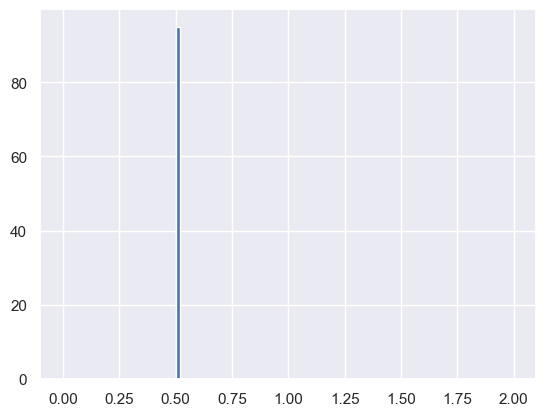

In [17]:
# проверим длительности поездок на наличие аномалий
df_rides['duration'].hist(bins=100, range=(0,2))

Больше 80 поездок отменено спустя 30 секунд после начала поездки. не будем учитывать эти данные в итоговой статистике, удалим эти значения.

<AxesSubplot:>

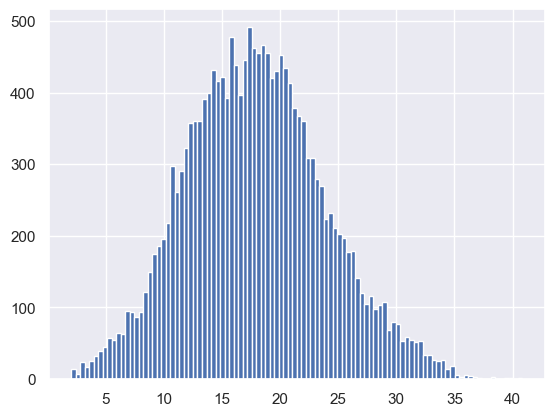

In [18]:
# оставляем в датафрейме значения с длительностью поездок больше минуты
df_rides = df_rides[df_rides['duration'] > 1]
# повторно выведем гистограмму для отображения распределения длительностей поездок
df_rides['duration'].hist(bins=100)

In [19]:
# выведем информацию о датафрейме после изменений
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   17973 non-null  int64         
 1   distance  17973 non-null  float64       
 2   duration  17973 non-null  float64       
 3   date      17973 non-null  datetime64[ns]
 4   month     17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 842.5 KB


В текущем датафрейме имеем 17973 значения. В первичном было 18068.

In [20]:
# оценим на сколько изменился датафрейм по объему по сравнению в первичным объемом
17973 / 18068

0.994742085454948

Датафрейм уменьшился менее, чем на 1% (допускается 10%). Переходим к `users`

Проверим наличие дубликатов в названиях городов таблицы `users`.

In [21]:
df_users['city'].value_counts()

Пятигорск         226
Екатеринбург      206
Ростов-на-Дону    202
Краснодар         196
Сочи              192
Омск              186
Тюмень            185
Москва            172
Name: city, dtype: int64

Как видим, представлены данные пользователей из 8 городов. Дубликаты в названиях отсутствуют.  

В таблице больше всего пользователей из Пятигорска, меньше всего из Москвы. Странно, должно бы быть наоборот, но такие уж данные нам предоставлены.

In [22]:
# Проверим кол-во пользователей в таблице rides
df_rides['user_id'].value_counts().count()

1534

In [23]:
# Проверим кол-во пользователей в таблице users
df_users['user_id'].value_counts().count()

1534

Кол-во различных пользователей в обоих таблицах совпадает.  
В таблице users кол-во id пользователей не совпадает с кол-вом всех значений в таблице. Выясним в чем дело.

Видно, что некоторые пользователи в таблице встречаются 2 раза.

In [24]:
# Выведем кол-во дубликатов
df_users['user_id'].duplicated().sum()

31

In [25]:
# Посмотрим на значения дубликатов
df_users.loc[df_users['user_id'].duplicated() == True]

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


In [26]:
# Удалим дубликаты с обновлением индексов
df_users = df_users.drop_duplicates('user_id', keep='last').reset_index()

In [27]:
# Посчитаем кол-во пользователей с подпиской или без
df_users.groupby('subscription_type')['subscription_type'].count()

subscription_type
free     835
ultra    699
Name: subscription_type, dtype: int64

In [28]:
# Распределим пользователей по подписке
df_users_ultra = df_users[df_users['subscription_type'] == 'ultra']
df_users_free = df_users[df_users['subscription_type'] == 'free']

**Выводы**  
Проведена предобработка данных: столбец с датой поездки приведен к необходимому типу данных, добавлен отдельный столбец с номерами месяцов совершения поездок, устранены дубликаты пользователей. Переходим к исследовательскому анализу данных.

## 3. Исследовательский анализ данных

### 3.1 Частота встречаемости городов

Количество пользователей из каждого города мы определили на этапе предобработки данных. Выведем данное значение повторно, а также построим столбчатую диаграмму распределения пользователей по разным городам

In [29]:
df_users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

In [30]:
# Выведем среднее значение пользователей на каждый город
df_users['city'].value_counts().mean()

191.75

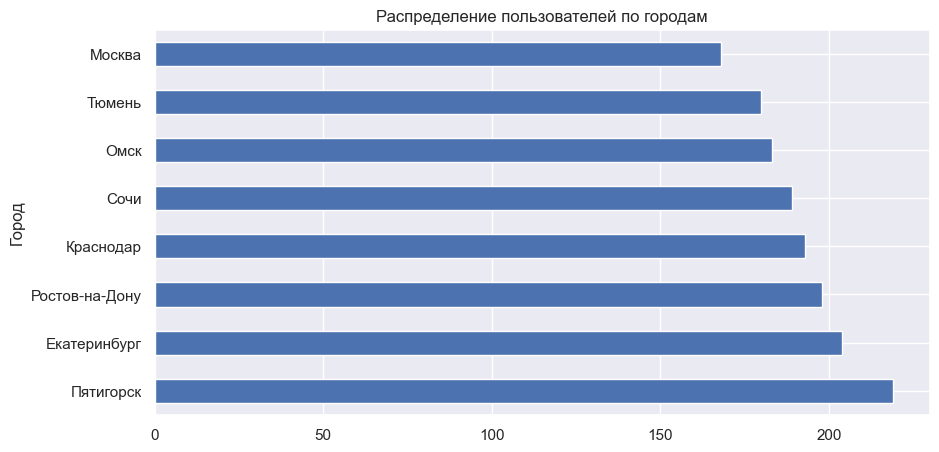

In [31]:
# Построим столбчатую диаграмму
users_city = df_users['city'].\
    value_counts().\
    plot(kind='barh', 
         figsize=(10, 5), 
         grid=True,
         xlabel='Город',
         ylabel='Количество пользователей',
         title='Распределение пользователей по городам')

Странно, что в таблице пользователей из Москвы - наименьшее количество, а из Пятигорска - наибольшее, но такие уж данные нам предоставлены.
В грубом приближении среднее значение пользователей на 1 город - 191 человек.

### 3.2 Соотношение пользователей с подпиской и без подписки

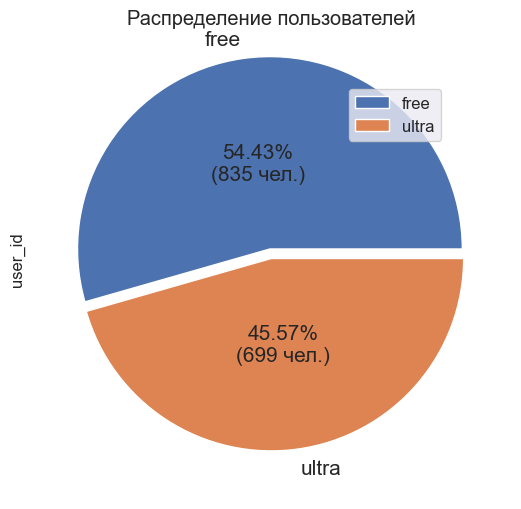

In [32]:
# Выведем кол-во пользователей с подпиской и без нее
all_users = df_users['user_id'].count()

def func_pct(pct):
    value = float(pct/100.*all_users)
    return "{:.2f}%\n({:.0f} чел.)".format(pct, value)

# сектор с подпиской выдвинем 
explode = (0.05, 0)

axes = df_users.groupby('subscription_type')['user_id'].count().plot(kind='pie',
                                                                     subplots=True,
                                                                     fontsize=15,
                                                                     use_index=False,
                                                                     explode=explode,
                                                                     title='Распределение пользователей',
                                                                     pctdistance=0.45,
                                                                     figsize=(20,5),
                                                                     autopct=lambda pct: func_pct(pct))

plt.tight_layout(pad=0)

for ax in axes:
    ax.legend(['free', 'ultra'], bbox_to_anchor=(0.87, 0.87), prop={'size':12})
    ax.set_label('')

Как видим, количество пользователей с подпиской и без подписки примерно одинаковая. Пользователей без подписки  незначительно больше - почти на 10% от общего числа представленных пользователей.

### 3.3 Возраст пользователей

Возраст самого младшего пользователя: 12
Возраст самого старшего пользователя: 43


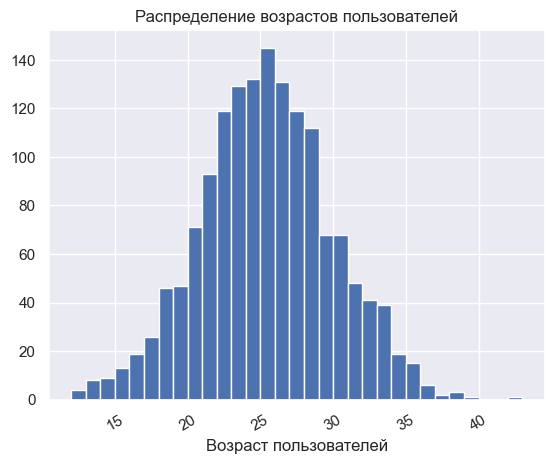

In [33]:
# Выведем самого младшего и самого старшего пользователей
print('Возраст самого младшего пользователя:', df_users['age'].min())
print('Возраст самого старшего пользователя:', df_users['age'].max())

# Построим гистрограмму распределения возрастов пользователей
plt.hist(df_users['age'], bins=31, range=(12, 43))
plt.grid(True) # включим отображение сетки
plt.xticks(rotation=30) # повернем название дат для корректного отображения
plt.xlabel('Возраст пользователей') # подпишем ось Х
plt.title('Распределение возрастов пользователей') # дадим название гистограмме
plt.show()

In [34]:
# выведем описание столбца
df_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Распределение пользователей по возрасту имеет нормальный вид.  
В предоставленной таблице имеются данные о пользователях с 12 до 43 лет, больше всего пользователей возрастной группы 22-28 лет.

### 3.4 Расстояние, которое пользователь преодолел за одну поездку

In [35]:
# Выведем описание столбца расстояний
df_rides['distance'].describe().round(2)

count    17973.00
mean      3059.86
std       1108.81
min          0.86
25%       2538.84
50%       3129.03
75%       3762.64
max       7066.00
Name: distance, dtype: float64

Минимальное преодоленное расстояние: 0.86
Максимальное преодоленное расстояние: 7066.0


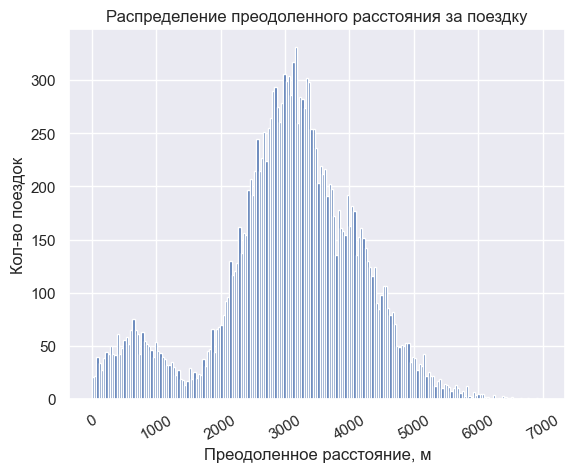

In [36]:
# Выведем минимальное и максимальное преодоленные расстояния в метрах
print('Минимальное преодоленное расстояние:', df_rides['distance'].min().round(2))
print('Максимальное преодоленное расстояние:', df_rides['distance'].max().round(2))

# Построим гистрограмму распределения преодоленных за одну поездку расстояний
plt.hist(df_rides['distance'], bins=200, range=(0, 7000))
plt.grid(True) # включим отображение сетки
plt.xticks(rotation=30) # повернем название дат для корректного отображения
plt.xlabel('Преодоленное расстояние, м') # подпишем ось Х
plt.ylabel('Кол-во поездок') # подпишем ось Y
plt.title('Распределение преодоленного расстояния за поездку') # дадим название гистограмме
plt.show()

Распределение преодоленного расстояния имеет нормальный вид.  
Больше всего людей проезжают на самокате за одну поездку около 3км, вероятнее всего это расстояния от дома до работы (и/или обратно). Также довольно много людей арендуют самокат для совершения коротких поездом меньше 1,5км.

### 3.5 Продолжительность поездок

In [37]:
# Выведем описание столбца продолжительности поездок
df_rides['duration'].describe().round(2)

count    17973.00
mean        17.90
std          5.98
min          2.04
25%         13.67
50%         17.71
75%         21.75
max         40.82
Name: duration, dtype: float64

Минимальная продолжительность поездки: 2.04
Максимальная продолжительность поездки: 40.82


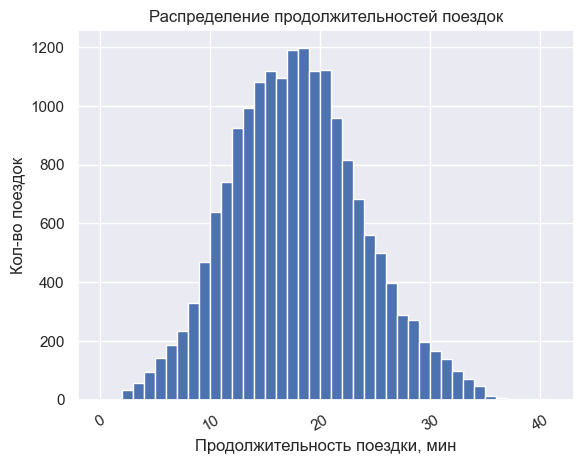

In [38]:
# Выведем минимальное и максимальное продолжительности поездок в минутах
print('Минимальная продолжительность поездки:', df_rides['duration'].min().round(2))
print('Максимальная продолжительность поездки:', df_rides['duration'].max().round(2))

# Построим гистрограмму распределения преодоленных за одну поездку расстояний
plt.hist(df_rides['duration'], bins=41, range=(0, 41))
plt.grid(True) # включим отображение сетки
plt.xticks(rotation=30) # повернем название дат для корректного отображения
plt.xlabel('Продолжительность поездки, мин') # подпишем ось Х
plt.ylabel('Кол-во поездок') # подпишем ось Y
plt.title('Распределение продолжительностей поездок') # дадим название гистограмме
plt.show()

Распределение продолжительностей поездок имеет нормальный вид. В около ста поездок пользователи завершали поездки менее, чем через минуту, после ее начала, возможно они обнаруживали какую-либо неисправность в самокате или просто передумывали ехать.  

Чаще всего на самокатах едут в течение 13-21 минуту. Поездки на самокате более 35 минут - редкость.

## 4. Объединение данных

### 4.1 Объединение данных о пользователях, поездках и подписках в один датафрейм

In [39]:
# оценим размерность датасетов
print('Размер датасета rides:', df_rides.shape[0])
print('Размер датасета users:', df_users.shape[0])

Размер датасета rides: 17973
Размер датасета users: 1534


Создадим таблицу, объединяющую данные о поздках, пользователях и подписках

In [40]:
rides_users = df_rides.merge(df_users, on='user_id', how='left').reset_index()
rides_users.head(10)

,level_0,user_id,distance,duration,date,month,index,name,age,city,subscription_type
0,0,1,4409.92,25.599769,2021-01-01,1,0,Кира,22,Тюмень,ultra
1,1,1,2617.59,15.816871,2021-01-18,1,0,Кира,22,Тюмень,ultra
2,2,1,754.16,6.232113,2021-04-20,4,0,Кира,22,Тюмень,ultra
3,3,1,2694.78,18.511000,2021-08-11,8,0,Кира,22,Тюмень,ultra
4,4,1,4028.69,26.265803,2021-08-28,8,0,Кира,22,Тюмень,ultra
5,5,1,2770.89,16.650138,2021-10-09,10,0,Кира,22,Тюмень,ultra
6,6,1,3039.02,14.927879,2021-10-19,10,0,Кира,22,Тюмень,ultra
7,7,1,2842.12,23.117468,2021-11-06,11,0,Кира,22,Тюмень,ultra
8,8,1,3412.69,15.238072,2021-11-14,11,0,Кира,22,Тюмень,ultra
9,9,1,748.69,15.041884,2021-11-22,11,0,Кира,22,Тюмень,ultra


In [41]:
# оцуним размерность объединенного датасета
rides_users.shape[0]

17973

Размерность объединенной таблицы совпадает с исходной. Проверим объединенный датафрейм на пропуски

In [42]:
# посмотрим долю пропусков
pd.DataFrame(round(rides_users.isna().mean().sort_values(ascending=False)*100,1)).style.background_gradient('coolwarm')

,0
level_0,0.000000
user_id,0.000000
distance,0.000000
duration,0.000000
date,0.000000
month,0.000000
index,0.000000
name,0.000000
age,0.000000
city,0.000000


Пропуски отсутствуют.

### 4.2 Создание дополнительных датафреймов

In [43]:
# Создаданим датафрейм содержащий данных о пользователях без подписки
rides_users_free = rides_users[rides_users['subscription_type'] == 'free']
rides_users_free.tail()

,level_0,user_id,distance,duration,date,month,index,name,age,city,subscription_type
17968,17968,1534,3781.10,19.822962,2021-11-04,11,1533,Альберт,25,Краснодар,free
17969,17969,1534,2840.42,21.409799,2021-11-16,11,1533,Альберт,25,Краснодар,free
17970,17970,1534,3826.19,18.435051,2021-11-18,11,1533,Альберт,25,Краснодар,free
17971,17971,1534,2902.31,16.674362,2021-11-27,11,1533,Альберт,25,Краснодар,free
17972,17972,1534,2371.71,15.893917,2021-12-29,12,1533,Альберт,25,Краснодар,free


In [44]:
# Создаданим датафрейм содержащий данных о пользователях с подпиской
rides_users_ultra = rides_users[rides_users['subscription_type'] == 'ultra']
rides_users_ultra.tail()

,level_0,user_id,distance,duration,date,month,index,name,age,city,subscription_type
6495,6495,699,3973.05,24.671163,2021-08-29,8,698,Оксана,22,Москва,ultra
6496,6496,699,3288.70,15.892886,2021-09-12,9,698,Оксана,22,Москва,ultra
6497,6497,699,3076.16,14.389525,2021-09-26,9,698,Оксана,22,Москва,ultra
6498,6498,699,4707.85,15.839579,2021-10-17,10,698,Оксана,22,Москва,ultra
6499,6499,699,3202.89,25.217345,2021-12-03,12,698,Оксана,22,Москва,ultra


### 4.3 Визуализация информации о расстоянии и времени поездок для пользователей обеих категорий

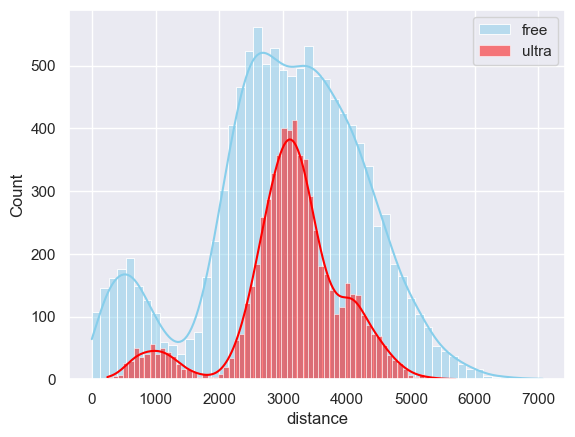

In [45]:
# выведем информацию о расстоянии, преодолеваемом за одну поездку для пользователей с подпиской и без подписки
sns.histplot(data=rides_users_free, x=rides_users_free['distance'], color="skyblue", label="free", kde=True)
sns.histplot(data=rides_users_ultra, x=rides_users_ultra['distance'], color="red", label="ultra", kde=True)

plt.legend() 
plt.show()

Можем заметить, что для пользователей с подпиской график имеет более узкий вид, что свидетельствует о меньшем стандартном отклонении в распределении.

Теперь построим график длительности одной поездки

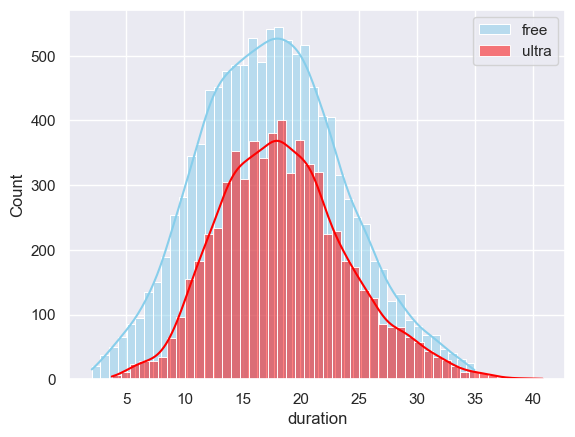

In [46]:
# выведем информацию о продолжительности поездок для пользователей с подпиской и без подписки
sns.set(style="darkgrid")

sns.histplot(data=rides_users_free, x=rides_users_free['duration'], color="skyblue", label="free", kde=True)
sns.histplot(data=rides_users_ultra, x=rides_users_ultra['duration'], color="red", label="ultra", kde=True)

plt.legend() 
plt.show()

На данном графике также прослеживается зависимость, что у пользователей с подпиской стандартной отклонение длительности одной поездки меньше, чем у пользователей без подписки.

**Вывод**  
Создали таблицы с объединенными данными по поездкам, пользователям и подпискам. С помощью данных таблиц построили графики зависимостей кол-ва совершенных поездок от длительности одной поездки и от преодоленной дистанции за поездку с отображением отдельно взятых поездок пользователй имеющих подписку и без нее.

## 5. Подсчет выручки

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными `rides_users`

Сделаем отдельную таблицу `users_dict`, которая будет содержать исключительно id пользователя и его подписку.

In [47]:
# Создадим сводную таблицу с длительностью всех совершенных поездок по месяцам для каждого пользователя
duration_pivot = df_rides.pivot_table(
    index = 'user_id',
    columns = 'month',
    values = 'duration',
    aggfunc = 'sum',
    fill_value = 0).round(2).reset_index().rename_axis(None, axis=1)

duration_pivot.tail(5)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
1529,1530,17.51,16.86,27.71,58.78,37.50,16.17,0.00,10.84,0.00,71.01,35.98,0.00
1530,1531,12.58,37.71,0.00,78.11,70.16,27.26,37.76,56.75,20.63,32.62,34.61,0.00
1531,1532,14.85,0.00,0.00,8.61,7.79,0.00,17.34,45.64,0.00,20.13,57.67,40.13
1532,1533,20.32,10.64,92.16,17.43,0.00,6.30,46.91,21.16,0.00,0.00,25.66,0.00
1533,1534,15.23,13.43,0.00,14.37,0.00,24.81,0.00,47.21,22.56,0.00,76.34,15.89


In [48]:
# Создадим сводную таблицу с количеством всех совершенных поездок по месяцам для каждого пользователя
count_pivot = df_rides.pivot_table(
    index = 'user_id',
    columns = 'month',
    values = 'duration',
    aggfunc = 'count',
    fill_value = 0).reset_index().rename_axis(None, axis=1)

count_pivot.tail(5)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
1529,1530,2,1,2,2,2,1,0,1,0,4,2,0
1530,1531,1,2,0,4,4,2,2,3,1,2,2,0
1531,1532,1,0,0,1,1,0,1,2,0,1,4,2
1532,1533,1,1,4,1,0,1,3,1,0,0,1,0
1533,1534,1,1,0,1,0,2,0,2,1,0,4,1


In [49]:
# Создадим сводную таблицу с преодоленной дистанцией всех совершенных поездок по месяцам для каждого пользователя
distance_pivot = df_rides.pivot_table(
    index = 'user_id',
    columns = 'month',
    values = 'distance',
    aggfunc = 'sum',
    fill_value = 0).round(2).reset_index().rename_axis(None, axis=1)

distance_pivot.tail(5)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
1529,1530,239.33,2724.33,6618.03,9846.65,7606.45,2587.07,0.00,2237.18,0.00,9211.48,5687.96,0.00
1530,1531,711.67,3022.48,0.00,13021.53,13526.16,4041.88,6163.69,10526.55,2544.43,7606.90,5889.51,0.00
1531,1532,2615.48,0.00,0.00,842.10,303.79,0.00,3735.88,8774.46,0.00,2891.12,8627.50,6111.89
1532,1533,3438.60,310.49,12822.70,2514.50,0.00,1035.00,8772.52,4581.94,0.00,0.00,3414.45,0.00
1533,1534,4678.42,2103.91,0.00,3434.29,0.00,3409.47,0.00,7622.45,4928.17,0.00,13350.02,2371.71


In [50]:
# Сделаем отдельную таблицу users_dict, которая будет содержать только id пользователей 
# и их тарифный план и объединим ее с таблицей df_subscriptions.
users_dict = df_users[['user_id', 'subscription_type']]
users_dict.tail(10)

users_subs_dict = users_dict.merge(df_subscriptions, on='subscription_type', how='left')
users_subs_dict.tail(5)

,user_id,subscription_type,minute_price,start_ride_price,subscription_fee
1529,829,free,8,50,0
1530,809,free,8,50,0
1531,307,ultra,6,0,199
1532,47,ultra,6,0,199
1533,1045,free,8,50,0


Теперь объединим новую таблицу со сводными таблицами по длительности поездок, расстояниям за одну поездку и кол-ву поездок по месяцам.   
Посчитаем, выручку сервиса в каждом месяце по формуле:  
стоимость подписки + (стоимость старта поездки * кол-во поездок в месяце) + (суммарная длительность поездок в месяц * стоимость 1 минуты поездки)

In [51]:
duration_data = duration_pivot.merge(users_subs_dict, on='user_id', how='right')
duration_data.tail(5)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,subscription_type,minute_price,start_ride_price,subscription_fee
1529,829,0.00,14.34,0.00,28.86,17.45,20.70,46.43,14.93,27.70,42.06,17.47,96.13,free,8,50,0
1530,809,17.50,17.86,0.00,0.00,0.00,0.00,22.34,23.14,0.00,0.00,30.15,0.00,free,8,50,0
1531,307,0.00,22.67,80.86,0.00,11.19,0.00,23.22,0.00,40.28,0.00,31.38,0.00,ultra,6,0,199
1532,47,0.00,14.31,0.00,0.00,22.30,32.02,0.00,15.72,0.00,0.00,10.19,6.82,ultra,6,0,199
1533,1045,46.74,29.33,0.00,29.41,16.74,0.00,11.65,16.36,11.97,7.25,34.12,19.53,free,8,50,0


In [52]:
for m in range(1,13): #проходим цикл по 12-ти месяцам
    duration_data[m] = np.ceil(duration_data[m]) # округляем длительность поездки до ближайшего большего целого
    duration_data[m] *= duration_data['minute_price'] # умножаем длительность поездок на стоимость 1 минуты поездки
    duration_data[m] += duration_data['subscription_fee'] # добавляем стоимость подписки
    
duration_data.tail()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,subscription_type,minute_price,start_ride_price,subscription_fee
1529,829,0.0,120.0,0.0,232.0,144.0,168.0,376.0,120.0,224.0,344.0,144.0,776.0,free,8,50,0
1530,809,144.0,144.0,0.0,0.0,0.0,0.0,184.0,192.0,0.0,0.0,248.0,0.0,free,8,50,0
1531,307,199.0,337.0,685.0,199.0,271.0,199.0,343.0,199.0,445.0,199.0,391.0,199.0,ultra,6,0,199
1532,47,199.0,289.0,199.0,199.0,337.0,397.0,199.0,295.0,199.0,199.0,265.0,241.0,ultra,6,0,199
1533,1045,376.0,240.0,0.0,240.0,136.0,0.0,96.0,136.0,96.0,64.0,280.0,160.0,free,8,50,0


In [53]:
# удалим из таблицы лишние столбцы
duration_data = duration_data.drop(columns = ['minute_price', 'start_ride_price', 'subscription_fee'])
duration_data.tail()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,subscription_type
1529,829,0.0,120.0,0.0,232.0,144.0,168.0,376.0,120.0,224.0,344.0,144.0,776.0,free
1530,809,144.0,144.0,0.0,0.0,0.0,0.0,184.0,192.0,0.0,0.0,248.0,0.0,free
1531,307,199.0,337.0,685.0,199.0,271.0,199.0,343.0,199.0,445.0,199.0,391.0,199.0,ultra
1532,47,199.0,289.0,199.0,199.0,337.0,397.0,199.0,295.0,199.0,199.0,265.0,241.0,ultra
1533,1045,376.0,240.0,0.0,240.0,136.0,0.0,96.0,136.0,96.0,64.0,280.0,160.0,free


In [54]:
count_data = count_pivot.merge(users_subs_dict, on='user_id', how='right')
count_data.tail()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,subscription_type,minute_price,start_ride_price,subscription_fee
1529,829,0,1,0,1,2,1,2,1,1,3,1,4,free,8,50,0
1530,809,1,1,0,0,0,0,1,2,0,0,2,0,free,8,50,0
1531,307,0,1,4,0,1,0,1,0,2,0,3,0,ultra,6,0,199
1532,47,0,1,0,0,1,2,0,1,0,0,1,1,ultra,6,0,199
1533,1045,2,2,0,2,1,0,1,1,1,1,2,1,free,8,50,0


In [55]:
for m in range(1,13): #проходим цикл по 12-ти месяцам
    count_data[m] *= count_data['start_ride_price'] # умножаем кол-во поездок на стоимость старта поездки

count_data.tail()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,subscription_type,minute_price,start_ride_price,subscription_fee
1529,829,0,50,0,50,100,50,100,50,50,150,50,200,free,8,50,0
1530,809,50,50,0,0,0,0,50,100,0,0,100,0,free,8,50,0
1531,307,0,0,0,0,0,0,0,0,0,0,0,0,ultra,6,0,199
1532,47,0,0,0,0,0,0,0,0,0,0,0,0,ultra,6,0,199
1533,1045,100,100,0,100,50,0,50,50,50,50,100,50,free,8,50,0


In [56]:
# удалим из таблицы лишние столбцы
count_data = count_data.drop(columns = ['minute_price', 'start_ride_price', 'subscription_fee'])
count_data.tail()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,subscription_type
1529,829,0,50,0,50,100,50,100,50,50,150,50,200,free
1530,809,50,50,0,0,0,0,50,100,0,0,100,0,free
1531,307,0,0,0,0,0,0,0,0,0,0,0,0,ultra
1532,47,0,0,0,0,0,0,0,0,0,0,0,0,ultra
1533,1045,100,100,0,100,50,0,50,50,50,50,100,50,free


Теперь имеется две таблицы с посчитанной выручкой. Для получения общей выручки необходимо их объединить.

In [57]:
df_revenue = pd.concat([duration_data, count_data], join='outer').reset_index(drop=True)

df_revenue = df_revenue.groupby(['subscription_type', 'user_id'], as_index=False).sum()

df_revenue.tail()

,subscription_type,user_id,1,2,3,4,5,6,7,8,9,10,11,12
1529,ultra,695,199.0,199.0,283.0,361.0,199.0,199.0,343.0,301.0,199.0,199.0,397.0,199.0
1530,ultra,696,199.0,199.0,373.0,199.0,199.0,295.0,199.0,307.0,199.0,199.0,199.0,199.0
1531,ultra,697,391.0,331.0,199.0,433.0,199.0,199.0,301.0,379.0,391.0,199.0,199.0,199.0
1532,ultra,698,553.0,271.0,199.0,199.0,199.0,283.0,493.0,361.0,307.0,283.0,199.0,199.0
1533,ultra,699,199.0,199.0,319.0,199.0,199.0,301.0,199.0,469.0,385.0,295.0,199.0,355.0


In [58]:
# создаем объединенный датафрейм
df_result = pd.DataFrame()
# округлим все поездки в исходном датафрейме до ближайшего большего целого
df_rides['duration'] = np.ceil(df_rides['duration'])

# сводная таблица по продолжительности и кол-ве поездок по месяцам
duration_per_month = df_rides.groupby(['user_id', 'month'])['duration'].agg(['count', 'sum']).reset_index()
duration_per_month.columns = ['user_id', 'month', 'count_rides', 'sum_duration']
# сводная таблица по расстоянию поездок по месяцам
distance_per_month = df_rides.groupby(['user_id', 'month'])['distance'].sum().reset_index()
distance_per_month.columns = ['user_id', 'month', 'sum_distance']
distance_per_month['sum_distance'] = distance_per_month['sum_distance'].round(2) 

display(duration_per_month.head(10))
display(distance_per_month.head(10))

,user_id,month,count_rides,sum_duration
0,1,1,2,42.0
1,1,4,1,7.0
2,1,8,2,46.0
3,1,10,2,32.0
4,1,11,3,56.0
5,1,12,2,28.0
6,2,3,3,63.0
7,2,4,2,40.0
8,2,6,1,14.0
9,2,7,2,48.0


,user_id,month,sum_distance
0,1,1,7027.51
1,1,4,754.16
2,1,8,6723.47
3,1,10,5809.91
4,1,11,7003.50
5,1,12,6751.63
6,2,3,10187.73
7,2,4,6164.39
8,2,6,3255.34
9,2,7,6780.73


Создадим из 3х таблиц `duration_per_month` и `distance_per_month` объединенную таблицу

In [59]:
df_result_1 = pd.merge(duration_per_month, distance_per_month, how='outer', on=['user_id', 'month'])
df_result_1

,user_id,month,count_rides,sum_duration,sum_distance
0,1,1,2,42.0,7027.51
1,1,4,1,7.0,754.16
2,1,8,2,46.0,6723.47
3,1,10,2,32.0,5809.91
4,1,11,3,56.0,7003.50
...,...,...,...,...,...
11295,1534,6,2,26.0,3409.47
11296,1534,8,2,48.0,7622.45
11297,1534,9,1,23.0,4928.17
11298,1534,11,4,78.0,13350.02


11300 значений по поездкам. Месяца, когда клиентом не было совершено ни одной поездки не включились в общий датафрейм

In [60]:
# Добавим в промежуточную таблицу тип подписки
df_result_2 = pd.merge(df_result_1, df_users, how='outer', on='user_id')
df_result_2 = df_result_2.drop(columns = ['index', 'name', 'city', 'age'])

display(df_result_2.head(10))

,user_id,month,count_rides,sum_duration,sum_distance,subscription_type
0,1,1,2,42.0,7027.51,ultra
1,1,4,1,7.0,754.16,ultra
2,1,8,2,46.0,6723.47,ultra
3,1,10,2,32.0,5809.91,ultra
4,1,11,3,56.0,7003.50,ultra
5,1,12,2,28.0,6751.63,ultra
6,2,3,3,63.0,10187.73,ultra
7,2,4,2,40.0,6164.39,ultra
8,2,6,1,14.0,3255.34,ultra
9,2,7,2,48.0,6780.73,ultra


In [61]:
# Добавим в итоговый датафрейм данные по подпискам
df_result = pd.merge(df_result_2, df_subscriptions, how='outer', on='subscription_type')

display(df_result.sample(10))

,user_id,month,count_rides,sum_duration,sum_distance,subscription_type,minute_price,start_ride_price,subscription_fee
10325,1416,6,1,18.0,2647.29,free,8,50,0
2840,436,2,1,16.0,3004.45,ultra,6,0,199
6771,981,6,2,37.0,5151.89,free,8,50,0
7752,1101,4,1,11.0,2984.92,free,8,50,0
9093,1263,8,2,32.0,5234.97,free,8,50,0
2120,324,1,2,38.0,5766.29,ultra,6,0,199
7314,1047,5,1,9.0,3241.31,free,8,50,0
3814,584,2,2,56.0,7641.70,ultra,6,0,199
6515,950,12,2,33.0,4232.09,free,8,50,0
196,32,1,1,25.0,3734.99,ultra,6,0,199


In [62]:
# рассчитаем в итоговый датафрейм помесячную выручку от каждого клиента
df_result['revenue'] = df_result['subscription_fee'] + \
(df_result['start_ride_price'] * df_result['count_rides']) + \
(df_result['sum_duration'] * df_result['minute_price'])

display(df_result.sample(10))

,user_id,month,count_rides,sum_duration,sum_distance,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
3228,497,2,1,15.0,3137.99,ultra,6,0,199,289.0
1098,168,9,1,20.0,2630.79,ultra,6,0,199,319.0
10057,1384,2,4,81.0,14687.29,free,8,50,0,848.0
164,26,6,2,39.0,6980.70,ultra,6,0,199,433.0
1845,281,12,2,43.0,6317.34,ultra,6,0,199,457.0
1966,300,3,1,16.0,2699.58,ultra,6,0,199,295.0
883,136,10,1,12.0,3533.65,ultra,6,0,199,271.0
5130,775,7,3,33.0,4704.38,free,8,50,0,414.0
2775,426,1,1,15.0,2759.54,ultra,6,0,199,289.0
4395,676,3,1,20.0,3528.96,ultra,6,0,199,319.0


In [63]:
# удалим лишние столбцы из итоговой таблицы
df_result = df_result.drop(columns = ['minute_price', 'start_ride_price', 'subscription_fee'])

In [64]:
display(df_result.sample(10))

,user_id,month,count_rides,sum_duration,sum_distance,subscription_type,revenue
6210,913,4,2,37.0,4530.17,free,396.0
2481,380,4,2,28.0,4076.04,ultra,367.0
5396,810,10,1,17.0,2909.26,free,186.0
9745,1345,12,1,7.0,586.73,free,106.0
1167,179,1,1,11.0,2905.28,ultra,265.0
4055,619,3,1,24.0,4282.06,ultra,343.0
3414,524,9,2,28.0,3837.94,ultra,367.0
10736,1467,10,1,14.0,4043.35,free,162.0
2339,358,12,1,16.0,1628.04,ultra,295.0
8424,1184,12,1,16.0,2316.37,free,178.0


In [65]:
# Выведем суммарную выручку от всех клиентов за год
df_result['revenue'].sum()

3873131.0

**Вывод**  
Произведен расчет общей выручки сервиса по аренде самокатов за год, с учетом тарифов с покупкой подписки и без нее.

## 6. Проверка гипотез

### 6.1 Гипотеза: тратят ли пользователи с подпиской больше времени на поездки

In [66]:
# Создадим сводную таблицу с длительностью всех совершенных поездок по месяцам для каждого пользователя
duration_pivot = df_rides.pivot_table(
    index = 'user_id',
    columns = 'month',
    values = 'duration',
    aggfunc = 'sum',
    fill_value = 0).round(2).reset_index().rename_axis(None, axis=1)

duration_pivot.tail(5)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
1529,1530,19,17,28,60,39,17,0,11,0,73,37,0
1530,1531,13,39,0,80,73,28,39,58,21,33,35,0
1531,1532,15,0,0,9,8,0,18,47,0,21,60,42
1532,1533,21,11,93,18,0,7,48,22,0,0,26,0
1533,1534,16,14,0,15,0,26,0,48,23,0,78,16


In [67]:
# Объединим сводную таблицу с данными пользовательских подписок
df_duration = duration_pivot.merge(users_subs_dict, on='user_id', how='right')
# удалим из таблицы лишние столбцы
df_duration = df_duration.drop(columns = ['minute_price', 'start_ride_price', 'subscription_fee'])
# округлим длительность поездки до ближайшего большего целого
for m in range(1,13): 
    df_duration[m] = np.ceil(df_duration[m]) 
    
df_duration.tail(5)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,subscription_type
1529,829,0.0,15.0,0.0,29.0,18.0,21.0,48.0,15.0,28.0,44.0,18.0,97.0,free
1530,809,18.0,18.0,0.0,0.0,0.0,0.0,23.0,24.0,0.0,0.0,31.0,0.0,free
1531,307,0.0,23.0,83.0,0.0,12.0,0.0,24.0,0.0,41.0,0.0,33.0,0.0,ultra
1532,47,0.0,15.0,0.0,0.0,23.0,33.0,0.0,16.0,0.0,0.0,11.0,7.0,ultra
1533,1045,47.0,30.0,0.0,31.0,17.0,0.0,12.0,17.0,12.0,8.0,35.0,20.0,free


Разделим датафрейм с длительностями поездок на два датафрейма в зависимости от имеющейся подписки

In [68]:
df_duration_free = df_duration[df_duration['subscription_type'] == 'free']
df_duration_ultra = df_duration[df_duration['subscription_type'] == 'ultra']

В данные датафреймы добавим столбец `total_duration` с общей длительностью поездок за год от каждого пользователя

In [69]:
df_duration_free['total_duration'] = df_duration_free.iloc[:,2:14].sum(axis=1)
df_duration_free.tail(5)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,subscription_type,total_duration
1523,1198,0.0,21.0,52.0,46.0,17.0,30.0,17.0,40.0,0.0,16.0,14.0,0.0,free,253.0
1527,1237,35.0,0.0,21.0,16.0,0.0,14.0,54.0,50.0,69.0,33.0,0.0,74.0,free,331.0
1529,829,0.0,15.0,0.0,29.0,18.0,21.0,48.0,15.0,28.0,44.0,18.0,97.0,free,333.0
1530,809,18.0,18.0,0.0,0.0,0.0,0.0,23.0,24.0,0.0,0.0,31.0,0.0,free,96.0
1533,1045,47.0,30.0,0.0,31.0,17.0,0.0,12.0,17.0,12.0,8.0,35.0,20.0,free,182.0


In [70]:
df_duration_ultra['total_duration'] = df_duration_ultra.iloc[:,2:14].sum(axis=1)
df_duration_ultra.tail(5)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,subscription_type,total_duration
1525,422,20.0,18.0,0.0,27.0,0.0,0.0,0.0,17.0,0.0,0.0,21.0,0.0,ultra,83.0
1526,611,0.0,19.0,0.0,0.0,14.0,12.0,11.0,38.0,0.0,0.0,16.0,25.0,ultra,135.0
1528,209,20.0,12.0,0.0,0.0,15.0,23.0,13.0,20.0,14.0,0.0,20.0,12.0,ultra,129.0
1531,307,0.0,23.0,83.0,0.0,12.0,0.0,24.0,0.0,41.0,0.0,33.0,0.0,ultra,216.0
1532,47,0.0,15.0,0.0,0.0,23.0,33.0,0.0,16.0,0.0,0.0,11.0,7.0,ultra,105.0


Оценим получившиеся датафреймы на выбросы:

In [71]:
# Сгруппируем датафрейм пользователей без подписки и выведем описание датафрейма
df_duration_free.groupby('subscription_type')['total_duration'].describe().round()

,count,mean,std,min,25%,50%,75%,max
subscription_type,,,,,,,,
free,835.0,226.0,67.0,58.0,180.0,224.0,272.0,443.0


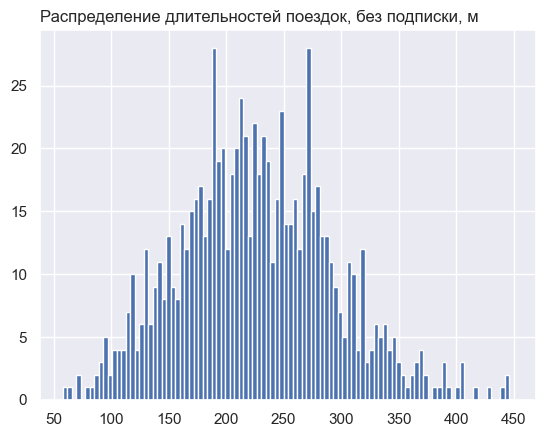

In [72]:
# Построим гистрограмму
df_duration_free.total_duration.hist(bins=100, range=(58,450))
plt.title('Распределение длительностей поездок, без подписки, м', loc = 'left')
plt.show()

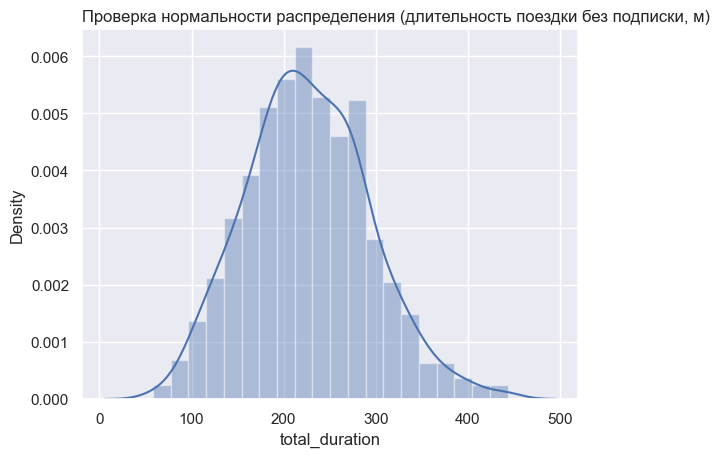

In [73]:
# Проверим распределение на нормальность
sns.distplot(df_duration_free['total_duration'])   
plt.title('Проверка нормальности распределения (длительность поездки без подписки, м)', loc = 'left')
plt.show()

Распределение длительностей поездок пользователей без подписки выглядит нормально. Переходим к пользователям с подпиской.

In [74]:
# Сгруппируем датафрейм пользователей без подписки и выведем описание датафрейма
df_duration_ultra.groupby('subscription_type')['total_duration'].describe().round()

,count,mean,std,min,25%,50%,75%,max
subscription_type,,,,,,,,
ultra,699.0,161.0,60.0,22.0,118.0,156.0,200.0,422.0


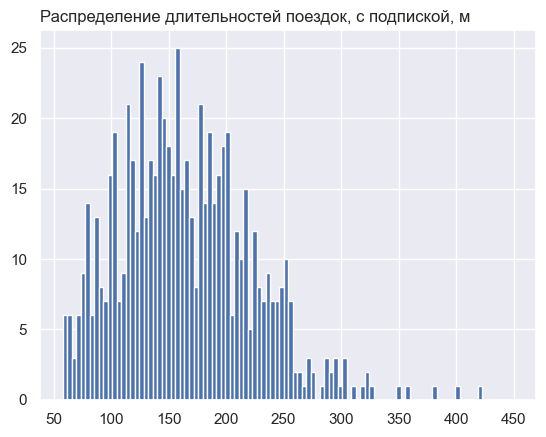

In [75]:
# Построим гистрограмму
df_duration_ultra.total_duration.hist(bins=100, range=(58,450))
plt.title('Распределение длительностей поездок, с подпиской, м', loc = 'left')
plt.show()

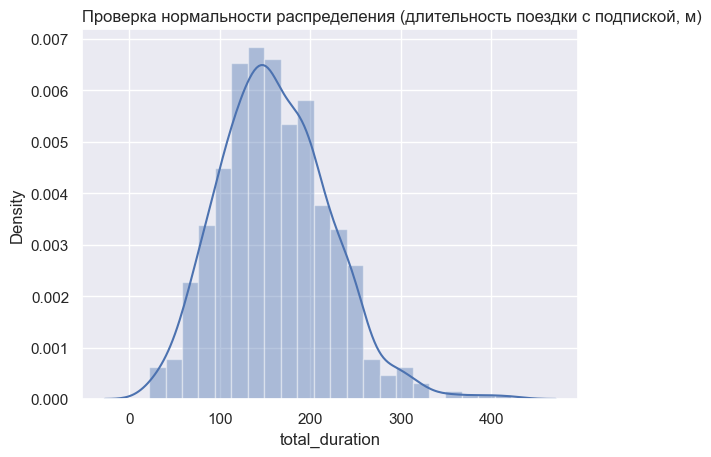

In [76]:
# Проверим распределение на нормальность
sns.distplot(df_duration_ultra['total_duration'])   
plt.title('Проверка нормальности распределения (длительность поездки с подпиской, м)', loc = 'left')
plt.show()

Распределение выручки пользователей с подпиской также выглядит нормально.

Введем основную и альтернативные гипотезы:
* **H0**: Средняя время поездки пользователей с подпиской и без подписки одинакова.
* **H1**: Среднее время поездки у пользователей с подпиской больше, чем у пользователей без подписки.

Уровень значимости: **alpha = 0.05**

Посчитаем p-value, используя `ttest` из библиотеки `scipy` для сравнения средних двух выборок.

У нас разные по размеру выборки (пользователей без подписки на 100 человек больше, чем пользователей с подпиской). Для подтверждения гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам иcпользуется метод `st.stats.ttest_ind`. Так же будем использовать параметр `equal_var=True`, т.к. отсутствуют сомнения по поводу нормального распределения дисперсий, судя по приведенным выше гистограммам.

Если p-value будет меньше выбранного уровня значимости **alpha = 0.05**, то нулевую гипотезу о равенстве средних отвергнем. В противном случае делаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [77]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(rides_users_ultra['duration'], rides_users_free['duration'], alternative='greater')

print('p-значение:', results.pvalue) # тест односторонний

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.7044680744539e-28
Отвергаем нулевую гипотезу


**Вывод**  
p-value больше выбранного уровня **alpha=0.05**. Отвергаем нулевую гипотезу, т.к. среднее время поездки у подписчиков больше, чем у пользователей без подписки.

Проверим вторую теорию.  

Введем основную и альтернативные гипотезы:
* средняя длительность поездок пользователей с подпиской и без подписки одинакова
* средняя длительность поездок пользователей с подпиской больше, чем средняя длительность поездок пользователей без подписки  

In [78]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(df_duration_ultra['total_duration'], df_duration_free['total_duration'], alternative='less')

# тест односторонний
print('p-значение: ', results.pvalue)

# отвергаем гипотезу только если выборочное среднее значимо меньше предполагаемого значения
if (results.pvalue < alpha) and (df_duration_ultra['total_duration'].mean() > df_duration_free['total_duration'].mean()):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  2.1124722645115124e-78
Не получилось отвергнуть нулевую гипотезу


**Вывод**  
p-value получилось больше выбранного уровня **alpha=0.05**. Отвергнуть нулевую гипотезу не получилось, средняя длительность поездок пользователей с подпиской и пользователей без подписки одинакова.

### 6.2 Гипотеза: расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

В п.4.2 создали два датафрейма содержащих данные о пользователях без подписки и с подпиской `rides_users_free` и `rides_users_ultra`. Так как гипотеза относится только к пользователям с подпиской, то оценим датафрейм `rides_users_ultra` на выбросы:

In [79]:
# Сгруппируем датафрейм пользователей без подписки и выведем описание датафрейма
rides_users_ultra.groupby('subscription_type')['distance'].describe().round()

,count,mean,std,min,25%,50%,75%,max
subscription_type,,,,,,,,
ultra,6500.0,3115.0,837.0,244.0,2785.0,3149.0,3561.0,5700.0


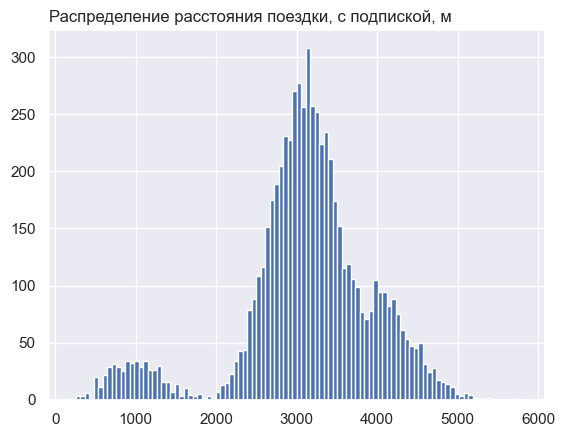

In [80]:
# Построим гистрограмму
rides_users_ultra.distance.hist(bins=100, range=(200,5800))
plt.title('Распределение расстояния поездки, с подпиской, м', loc = 'left')
plt.show()

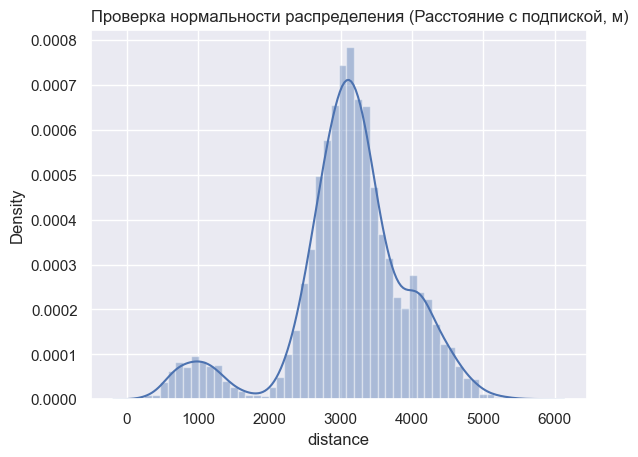

In [81]:
# Проверим распределение на нормальность
sns.distplot(rides_users_ultra['distance'])   
plt.title('Проверка нормальности распределения (Расстояние с подпиской, м)', loc = 'left')
plt.show()

Допускаем, что набор данных расстояния, преодолеваемого за поездку распределено нормально.

Введем основную и альтернативные гипотезы:
* **H0**: среднее расстояние, которые преодолевают пользователи с подпиской равно 3130 метров
* **H1**: среднее расстояние, которые преодолевают пользователи с подпиской не равно 3130 метров

Уровень значимости: **alpha = 0.05**

Посчитаем p-value, используя `ttest` из библиотеки `scipy` для сравнения средних двух выборок.
1samp. Так же будем использовать параметр `alternative`. Сначала проверим двустороннюю гипотезу без указания данного параметра, а потом - левостороннюю с указанием `alternative='less'`.

Если p-value будет меньше выбранного уровня значимости **alpha = 0.05**, то нулевую гипотезу о равенстве заданному среднему значению отвергнем. В противном случае делаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [82]:
optimal_value = 3130 # расстояние

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(
    rides_users_ultra['distance'],
    optimal_value,)

print('p-значение:', results.pvalue)

if results.pvalue < alpha: # сравним полученный p-value и уровень значимости
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.16092747883151715
Не получилось отвергнуть нулевую гипотезу


**Вывод**  
p-value получилось больше 10%б нулевую гипотезу не отвергаем - среднее расстояние, которые преодолевают пользователи с подпиской равно 3130 метров.

Проверим вторую теорию.

Введем основную и альтернативные гипотезы:
* H0: Среднее расстояние, которые преодолевают пользователи с подпиской не превышает 3130 метров
* H1: Подписчики в среднем проезжают расстояние больше оптимального

Альтернативную гипотезу сформируровали исходя из того, что при превышении "оптимального" по износу расстояния 3130 м - механические части самоката приходят к повышенному износу.

In [83]:
interested_value = 3130 # расстояние

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(
    rides_users_ultra['distance'],
    interested_value,
    alternative='greater') 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha): # сравним полученный p-value и уровень значимости
    print('Отвергаем нулевую гипотезу: подписчики в среднем проезжают расстояние больше оптимального')
else:
    print('Не получилось отвергнуть нулевую гипотезу: расстояние преодолеваемое подписчиками не превышает указанное')

p-значение: 0.9195362605842414
Не получилось отвергнуть нулевую гипотезу: расстояние преодолеваемое подписчиками не превышает указанное


**Вывод**  
p-value больше заданного уровня значимости **alpha=0.05**. Нулевую гипотезу не отвергаем - среднее расстояние, преодолеваемое пользователями с подпиской за одну поездку не превышает 3130 метров.

### 6.3 Гипотеза: будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Разделим датафрейм с общей выручкой на два датафрейма в зависимости от имеющейся подписки

In [84]:
df_result_free = df_result[df_result['subscription_type'] == 'free']
df_result_ultra = df_result[df_result['subscription_type'] == 'ultra']

display(df_result_free.tail(5))
display(df_result_ultra.tail(5))

,user_id,month,count_rides,sum_duration,sum_distance,subscription_type,revenue
11295,1534,6,2,26.0,3409.47,free,308.0
11296,1534,8,2,48.0,7622.45,free,484.0
11297,1534,9,1,23.0,4928.17,free,234.0
11298,1534,11,4,78.0,13350.02,free,824.0
11299,1534,12,1,16.0,2371.71,free,178.0


,user_id,month,count_rides,sum_duration,sum_distance,subscription_type,revenue
4528,699,6,1,17.0,4072.80,ultra,301.0
4529,699,8,2,45.0,7018.33,ultra,469.0
4530,699,9,2,31.0,6364.86,ultra,385.0
4531,699,10,1,16.0,4707.85,ultra,295.0
4532,699,12,1,26.0,3202.89,ultra,355.0


In [85]:
df_revenue_free = df_revenue[df_revenue['subscription_type'] == 'free']
df_revenue_ultra = df_revenue[df_revenue['subscription_type'] == 'ultra']

В данные датафреймы добавим столбец `total_revenue` с общей выручкой от каждого пользователя за год

In [86]:
df_revenue_free['total_revenue'] = df_revenue_free.iloc[:,2:14].sum(axis=1)
df_revenue_free.tail(5)

,subscription_type,user_id,1,2,3,4,5,6,7,8,9,10,11,12,total_revenue
830,free,1530,244.0,186.0,324.0,572.0,404.0,186.0,0.0,138.0,0.0,776.0,388.0,0.0,3218.0
831,free,1531,154.0,404.0,0.0,832.0,768.0,324.0,404.0,606.0,218.0,364.0,380.0,0.0,4454.0
832,free,1532,170.0,0.0,0.0,122.0,114.0,0.0,194.0,468.0,0.0,218.0,664.0,428.0,2378.0
833,free,1533,218.0,138.0,944.0,194.0,0.0,106.0,526.0,226.0,0.0,0.0,258.0,0.0,2610.0
834,free,1534,178.0,162.0,0.0,170.0,0.0,300.0,0.0,484.0,234.0,0.0,816.0,178.0,2522.0


In [87]:
df_revenue_ultra['total_revenue'] = df_revenue_ultra.iloc[:,2:14].sum(axis=1)
df_revenue_ultra.tail(5)

,subscription_type,user_id,1,2,3,4,5,6,7,8,9,10,11,12,total_revenue
1529,ultra,695,199.0,199.0,283.0,361.0,199.0,199.0,343.0,301.0,199.0,199.0,397.0,199.0,3078.0
1530,ultra,696,199.0,199.0,373.0,199.0,199.0,295.0,199.0,307.0,199.0,199.0,199.0,199.0,2766.0
1531,ultra,697,391.0,331.0,199.0,433.0,199.0,199.0,301.0,379.0,391.0,199.0,199.0,199.0,3420.0
1532,ultra,698,553.0,271.0,199.0,199.0,199.0,283.0,493.0,361.0,307.0,283.0,199.0,199.0,3546.0
1533,ultra,699,199.0,199.0,319.0,199.0,199.0,301.0,199.0,469.0,385.0,295.0,199.0,355.0,3318.0


Оценим получившиеся датафреймы на выбросы:

In [88]:
# Сгруппируем датафрейм пользователей без подписки и выведем описание датафрейма
df_revenue_free.groupby('subscription_type')['total_revenue'].describe().round()

,count,mean,std,min,25%,50%,75%,max
subscription_type,,,,,,,,
free,835.0,2646.0,733.0,664.0,2174.0,2580.0,3136.0,4974.0


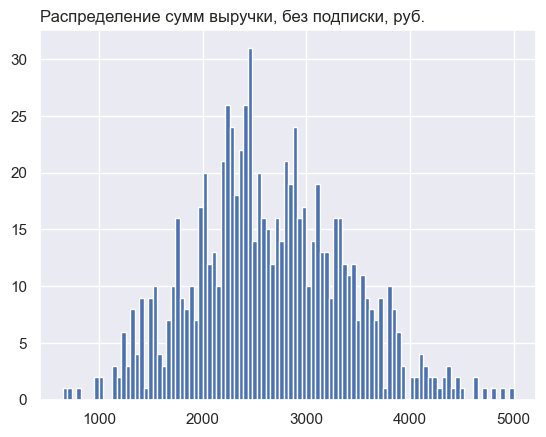

In [89]:
# Построим гистрограмму
df_revenue_free.total_revenue.hist(bins=100, range=(650,5000))
plt.title('Распределение сумм выручки, без подписки, руб.', loc = 'left')
plt.show()

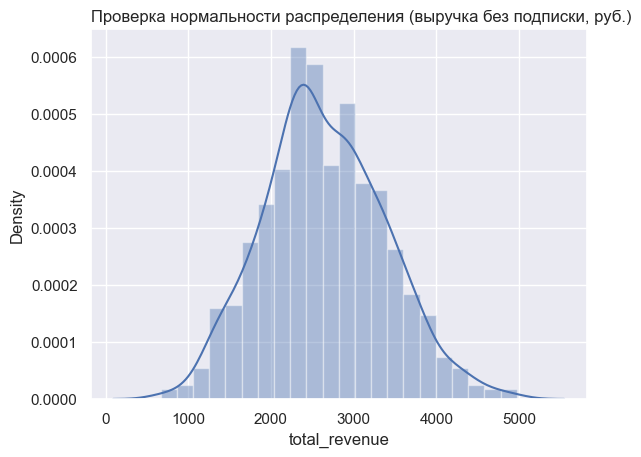

In [90]:
# Проверим распределение на нормальность
sns.distplot(df_revenue_free['total_revenue'])   
plt.title('Проверка нормальности распределения (выручка без подписки, руб.)', loc = 'left')
plt.show()

Распределение выручки пользователей без подписки выглядит нормально. Переходим к пользователям с подпиской.

In [91]:
# Сгруппируем датафрейм пользователей с подпиской и выведем описание датафрейма
df_revenue_ultra.groupby('subscription_type')['total_revenue'].describe().round()

,count,mean,std,min,25%,50%,75%,max
subscription_type,,,,,,,,
ultra,699.0,3441.0,371.0,2598.0,3162.0,3426.0,3669.0,4890.0


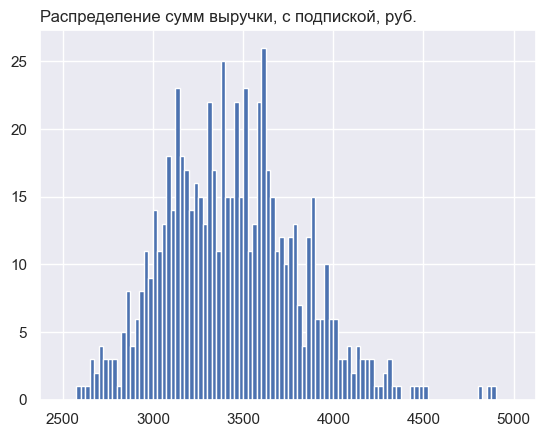

In [92]:
# Построим гистрограмму
df_revenue_ultra.total_revenue.hist(bins=100, range=(2500,5000))
plt.title('Распределение сумм выручки, с подпиской, руб.', loc = 'left')
plt.show()

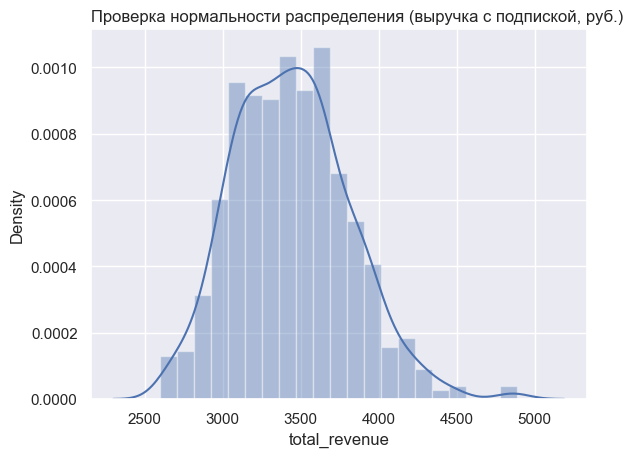

In [93]:
# Проверим распределение на нормальность
sns.distplot(df_revenue_ultra['total_revenue'])   
plt.title('Проверка нормальности распределения (выручка с подпиской, руб.)', loc = 'left')
plt.show()

Распределение выручки пользователей с подпиской также выглядит нормально.

Введем основную и альтернативные гипотезы:
* **H0**: средняя выручка пользователей с подпиской и без подписки одинакова
* **H1**: средняя месячная выручка у пользователей с подпиской выше чем у пользователей без подписки

Уровень значимости: **alpha = 0.05**

Посчитаем p-value, используя `ttest` из библиотеки `scipy` для сравнения средних двух выборок.

У нас разные по размеру выборки (пользователей без подписки на 100 человек больше, чем пользователей с подпиской). Для подтверждения гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам иcпользуется метод `st.stats.ttest_ind`. Так же будем использовать параметр `equal_var=True`, т.к. отсутствуют сомнения по поводу нормального распределения дисперсий, судя по приведенным выше гистограммам.

Если p-value будет меньше выбранного уровня значимости **alpha = 0.05**, то нулевую гипотезу о равенстве средних отвергнем. В противном случае делаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [94]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(df_result_ultra['revenue'], df_result_free['revenue'])

print('p-значение:', results.pvalue) # тест односторонний

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.0628227349726575e-30
Отвергаем нулевую гипотезу


**Вывод**  
p-value больше выбранного уровня **alpha=0.05**. Отвергаем нулевую гипотезу, т.к. выручки от пользователей с подпиской и без подписки различаются.

Проверим вторую теорию.  

Введем основную и альтернативные гипотезы:
* средняя выручка пользователей с подпиской и без подписки одинакова
* средняя выручка пользователей с подпиской больше, чем средняя выручка пользователей без подписки  

In [95]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(df_result_ultra['revenue'], df_result_free['revenue'], alternative='greater')

# тест односторонний: p-value будет в два раза меньше
print('p-значение: ', results.pvalue)

# тест односторонний влево:
# отвергаем гипотезу только если выборочное среднее значимо меньше предполагаемого значения
if (results.pvalue < alpha) and (df_revenue_ultra['total_revenue'].mean() > df_revenue_free['total_revenue'].mean()):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  2.0314113674863288e-30
Отвергаем нулевую гипотезу


**Вывод**  
p-value получилось меньше выбранного уровня **alpha=0.05**. Отвергаем нулевую гипотезу. Средняя выручка от пользователей с подпиской больше, чем средняя выручка от пользователей без подписки.

### 6.4 Гипотеза: количество обращений в техподдержку значимо снизилось после обновления сервера, с с которым взаимодействует приложение

Ситуациа: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Ответ**  

Для проверки данной гипотезы понадобился бы односторонний тест с использованием метода `scipy.stats.ttest_1samp()`. В качестве аргумента указывали бы `alternative='less'` для левосторонней H1 соответственно.  
P-value, которое выдаст метод, будет рассчитываться для одного хвоста распределения.

## 7. Распределение

### 7.1 Минимальное количество промокодов для выполнение плана платежей

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

**Решение**  
Для решения данной задачи будем использовать биномиальное распределение, так как у нас может быть только два исхода: клиент продлил подписку или нет, и метод `binom.pmf()` из модуля `scipy.stats` - он помогает получить вероятности биномиального распределения.  

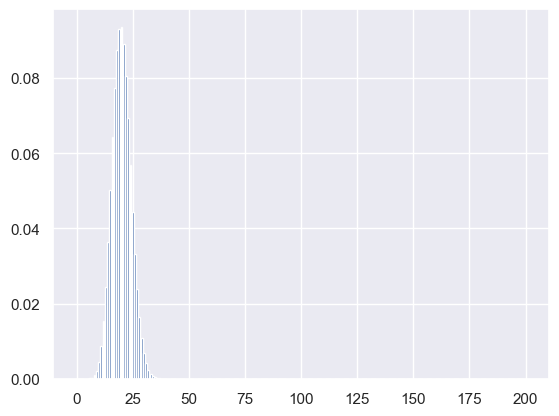

In [96]:
n = 200 # количество выданных промокодов
p = 0.1 # вероятность успеха

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr);

Видно, что при количестве выданных промокодов, равных 200, вероятнее всего только около 20 клиентов продлят подписку. Зададим параметры для функции биномиального распределения и используем цикл и посчитаем вероятность, пока она не достигнет заданной.

In [97]:
# Вариант с вычисленим неудач
from scipy.stats import binom
import numpy as np

p = 0.1
n = 800

# Начать можно с ~900.
for n in range(800, 1800):
    if binom.cdf(99, n, p) <= 0.05:
      print("Минимальное количество промокодов: ", n)
      break

Минимальное количество промокодов:  1161


**Вывод**  
Для того, чтобы как минимум 100 человек продлили подписки, необходимо раздать 1161 промокодов, при более низком количестве выданных промокодов вероятнее всего не удастся достигнуть требуемого выполнения плана платежей.

### 7.2 Вероятность открытия уведомления пользователем

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей. 

**Решение**  
Данная ситуация так же описывается биномиальным распределением: пользователь либо открыл уведомление, либо нет. Распределение Пуассона к решению данной задачи не подходит, т.к. у нас довольно большая вероятность успеха, будем аппроксимировать нормальным распределением. Задачу будем решать при помощи методов `binom` и `norm` из библиотеку `skipy.stats`. Математическое ожидание и стандартное отклонение нормального распределения, которым будем аппроксимировать биномиальное, возьмем равными мат.ожиданию и стандартному отклонению этого биномиального распределения.

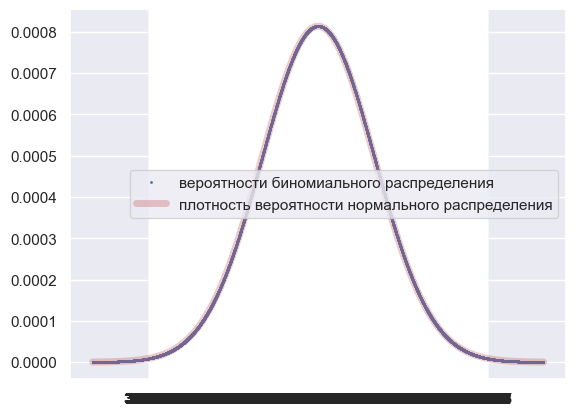

Условие выполняется


In [98]:
def linspace(start, stop, num):
    '''
    Выдаёт <num> чисел, равномерно распределенных 
    от <start> до <stop>
    (необходима для визуализации нормального распределения)
    '''
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
 
# задаём параметры биномиального распределения
n = 1000000 # кол-во отправленных уведомлений
p = 0.4 # вероятность открытия уведомления

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
 
# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
# рисуем график биномиального распределения
ax = plt.subplot()
# используем синие о-образные маркеры и размер маркера 1
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=1,
	      label='вероятности биномиального распределения')

# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
 
# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = linspace(left, right, 100)
# используем красную линию ширины 5 и прозрачности 0.3
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=5, alpha=0.3, label='плотность вероятности нормального распределения')
 
# зададим подписи по оси x в пределах ± 3 ст.отклонений от мат.ожидания
# (последний аргумент в методе range - интервал между подписями)
x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma), 1))
ax.set_xticks(x_ticks)

# настраиваем оптимальное расположение легенды и выводим график
ax.legend(loc='best')
plt.show()

# выводим, выполняется ли наше условие аппроксимации:
# лежит ли mu ± 3 sigma в промежутке от 0 до n:
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие выполняется')
else:
    print('Условие не выполняется')

Аппроксимацией работает хорошо, что подтверждается графиком - линии вероятности биномиального распределения и плостности вероятности нормального распределения совпадают. 

Рассчитаем вероятность "хвоста" распределения - 399,5 тыс.пользователей. Для этого воспользуемся аппроксимацией нормальным распределением и методом `cdf()`.

In [99]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева от 399,5 тысяч
result = distr.cdf(399500)
print(result)

0.15371708296369768


**Вывод**  
Вероятность, что уведовление откроют менее 399,5тыс. пользователей из 1млн отправленных уведомлений составляет чуть больше 15%. Таким образом, более вероятно, что отдел маркетинга выполнит план по количеству открытых push-уведомлений.

## Общий вывод

Проведена аналитика сервиса по аренде самокатов GoFast:  
* проведен обзор предоставленных данных - 3 таблицы: с данными пользователей, совершенных поездок за 2021 год и описание каждого тарифа (с подпиской или без);
* провели предобработку данных, выяснили из каких городов представлены пользователи, выяснили, что больше всего пользователей представлено из Пятигорска, а меньше всего из Москвы;
* исследовали данные: выяснили, что пользователей без подписки почти на 100 человек больше, чем пользователей с подпиской; определили, что чаще всего пользуются приложением люди, возрастом 25 лет; за одну поездку проезжают около 3км и едут в среднем 20 минут;
* рассчитали годовую выручку от всех пользователей - она составила почти 400тыс.руб.;
* выяснили, что средняя длительность поездок пользователей с подпиской и пользователей без подписки одинакова;
* средняя выручка от пользователей с подпиской больше, чем средняя выручка от пользователей без подписки;
* подтвердили гипотезу, что среднее расстояние, преодолеваемое пользователями с подпиской за одну поездку не превышает 3130 метров;
* подсчитали, что для того, чтобы 100 человек продлили подписку после получения бесплатного промокода, ориентировочно нужно раздать 1161 промокодов;
* узнали, что с вероятностью почти 85% push-уведомление откроют более 400тыс. пользователей из 1млн. отправленных уведомлений.


### Рекомендации для сервиса GoFast  
* необходимо произвести донастройку серверов, т.к. в данных встречаются дубликаты;
* проводить акции для того, чтобы пользователи больше покупали подписки, т.к. от пользователей с подписками идет больше выручки
* рассмотреть другие маркетологические инструменты, помимо выдачи промокодов, т.к. по ним овольно низкий процент продления подписки
